# Importing libraries

In [ ]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

In [77]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
import geopy.distance
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math
import yaml
import pickle
import time
from scipy.sparse.csgraph import floyd_warshall

# Data

## Configs

In [78]:
with open("configs/params.yaml", "r") as f:
    config = yaml.safe_load(f)
    params = config

## City graph

In [79]:
def create_graph_network(city_params):
    G = ox.graph_from_place(city_params["name"], network_type = city_params["graph_type"])
    G.to_undirected()
    return G

In [80]:
G = ox.graph_from_place(params["city"]["name"], network_type="drive")

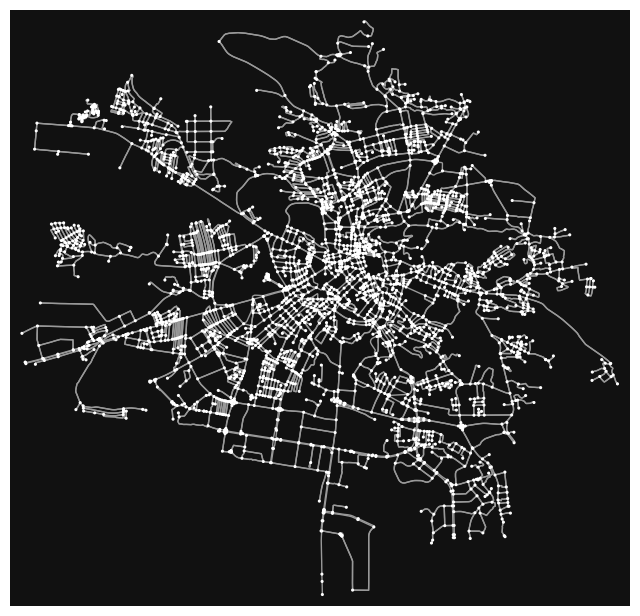

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [81]:
ox.plot_graph(G, node_size=5)

In [170]:
G_kyiv = ox.graph_from_place("Kyiv", network_type="drive")

## Division into sectors

In [82]:
def division_into_secors(city_params):
    city_boundary = ox.geocode_to_gdf(city_params["name"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [83]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=["index_right"]) 
    missing_nodes = nodes_in_grid[nodes_in_grid["index_right"].isna()]

    tree = cKDTree(assigned_nodes[["x", "y"]].values)
    _, nearest_idx = tree.query(missing_nodes[["x", "y"]].values)

    nodes_in_grid.loc[nodes_in_grid["index_right"].isna(), "index_right"] = assigned_nodes.iloc[nearest_idx]["index_right"].values
    nodes_in_grid["index_right"] = nodes_in_grid["index_right"].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)["osmid"].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index("osmid")["index_right"].to_dict()
    regions = [region for region in region_to_nodes]

    return regions, region_to_nodes, node_to_region


## Calculating population for each region

Population for each region

In [84]:
def population_estimation(regions, map_with_grid, city_params):
    
    # Population count for each sector
    raster_file_population = city_params["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
    map_with_grid = map_with_grid.reset_index()

    # Creating dictionary: region -> population
    region_to_populatoin = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]["index"]
        if region_id in regions:
            population = map_with_grid.iloc[grid_cell]["population"]
            region_to_populatoin[region_id] = population
    
    return region_to_populatoin

## Distance matrix

In [85]:
def calculate_distamnce_matrix(G):
    nodes = list(G.nodes)
    n = len(nodes)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # Creating adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        D[j, i] = length
    np.fill_diagonal(D, 0)

    # Using optimized Floyd-Warshall
    D = floyd_warshall(D, directed=False)
    np.save("distance_matrix_lviv.npy", D)
    return D


In [86]:
def distance_matrix(G, city_params):
    if city_params["distance_matrix"]:
        return np.load(city_params["distance_matrix"])
    return calculate_distamnce_matrix(G)

## Substations

In [87]:
def find_substations(city_name):
    substations = ox.features_from_place(city_name, tags={"power": "substation"})
    substations = substations[['geometry']].reset_index()
    return substations

In [88]:
def calculate_distance_to_substation(G, substations):
    dist_to_substation = dict()
    for node in G.nodes():
        node_lat, node_lon = G.nodes[node]['y'], G.nodes[node]['x']
        distances = []
        for _, row in substations.iterrows():
            if row.geometry.geom_type == "Point":
                substation_lat, substation_lon = row.geometry.y, row.geometry.x
                distance_m = geopy.distance.geodesic((node_lat, node_lon), (substation_lat, substation_lon)).m
                distances.append(distance_m)
        dist_to_substation[node] = min(distances)
    return dist_to_substation

# Demand simulation

## Data Preperation

In [89]:
def create_cs_dataframe(solution, station_params):
    # Merge installed station and solution station data
    station_node_list, capacity_list, station_ports_list  = [], [], []

    for (station_node, station_type), station_ports in solution.items():
        capacity = station_params["types"][station_type]["capacity"]

        station_node_list.append(station_node)
        capacity_list.append(capacity)
        station_ports_list.append(station_ports)

    # Create station dataframes
    charging_station_df = pd.DataFrame({
        "cs_id": range(len(station_node_list)),
        "node": station_node_list,
        "capacity": capacity_list,
        "num_of_ports": station_ports_list,
    })
    return charging_station_df

In [90]:
def create_cs_occupation_dataframe(charging_station_df, simulation_hours):
    cs_occupation_df = pd.DataFrame(columns=["cs_id", "capacity", "port", "hour", "occupation_time"])
    
    for _, row in charging_station_df.iterrows():
        cs_id = row["cs_id"]
        capacity = row["capacity"]
        number_of_ports = int(row["num_of_ports"])

        # Creating rows for each port and hour
        for port in range(1, number_of_ports + 1):
            for hour in range(simulation_hours):
                cs_occupation_df.loc[len(cs_occupation_df)] = {"cs_id": cs_id, "capacity": capacity, "port": port, "hour": hour, "occupation_time": 0.0}

    cs_occupation_df["cs_id"] = cs_occupation_df["cs_id"].astype(int)
    return cs_occupation_df

## EV generation

In [91]:
def generate_route(ev, nodes):
    locations = []
    departure_times = []

    # Fron home
    home_location = ev["home_location"]
    morning_commute_hour = ev["commute_hours"]["morning"]
    
    # Route destinations
    number_of_destinations = random.choices([1, 2, 3], weights = [0.6, 0.3, 0.1], k=1)[0] # Generating number of destinations that are not home
    
    locations.append(home_location) # Home location (start point)
    random_locations = random.choices(nodes, k = number_of_destinations) # Work and other locations
    for location in random_locations:
        while location == home_location:
                location = random.choice(nodes)
        locations.append(location)
    locations.append(home_location) # Home location (end point)

    # Route times
    trip_time = {
        "random morning trip": range(0, ev["commute_hours"]["morning"]),
        "random noon trip": range(ev["commute_hours"]["morning"], ev["commute_hours"]["evening"]),
        "random evening trip": range(ev["commute_hours"]["evening"], 24)
    }
    
    departure_times.append(morning_commute_hour) # Departure to work

    if number_of_destinations > 1:
        for i in range(number_of_destinations-1):
            ranom_trip_type = random.choice(["random morning trip", "random noon trip", "random evening trip"])
            random_trip_time = random.choice(trip_time[ranom_trip_type])
            departure_times.append(random_trip_time)

    departure_times.append(ev["commute_hours"]["evening"]) # Departure from work
    departure_times.sort()

    parking_periods = []
    for i in range(number_of_destinations + 2): # +2 since the route starts and ends at home
        if i == 0:
            parking_periods.append([0, departure_times[i]-1])
        elif i == number_of_destinations + 1:
            parking_periods.append([departure_times[i-1], 23])
        else:
            parking_periods.append([departure_times[i-1], departure_times[i]-1])
    return locations, parking_periods

In [92]:
def generate_EVs(regions, region_to_population, region_to_nodes, nodes, params):
    EVs = []
    ev_id = 0

    for region in regions:
        ev_num = int(region_to_population[region] * params["ev"]["ev_per_capita"])

        potential_home_locations = region_to_nodes[region]
        if len(potential_home_locations) == 0:
            break
        ev_home_locations = random.choices(potential_home_locations, k = ev_num)
        for i in range(ev_num):
            battery_capacity = params["ev"]["battery_capacity"]
            initial_soc_range = params["simulation"]["initial_soc_range"]
            charging_threshold = params["simulation"]["charging_threshold"]
            target_charge = params["simulation"]["target_charge"]
            morning_commute_hours = params["simulation"]["commute_hours"]["morning"]
            evening_commute_hours = params["simulation"]["commute_hours"]["evening"]

            ev = {
                    "ev_id": ev_id,
                    "home_location": ev_home_locations[i],
                    "previous_location": ev_home_locations[i],
                    "battery_capacity": random.uniform(battery_capacity[0], battery_capacity[1]),
                    "current_charge": None,  # Will be assigned below
                    "charging_threshold": random.uniform(charging_threshold[0], charging_threshold[1]),  # When to start charging
                    "target_charge": random.uniform(target_charge[0], target_charge[1]),  # Target charge level
                    "commute_hours": {
                        "morning": random.randint(morning_commute_hours[0], morning_commute_hours[1]),  # Morning commute hour (6-9 AM)
                        "evening": random.randint(evening_commute_hours[0], evening_commute_hours[1])  # Evening commute hour (4-7 PM)
                    },
                    "destinations": None,  # Will be assigned below
                    "parking_periods": None  # Will be assigned below
            }
            
            # Assigning current state of charge
            ev["current_charge"] = ev["battery_capacity"] * random.uniform(initial_soc_range[0], initial_soc_range[1])

            # Assigning route (destinations + departure_times)
            destinations, parking_periods = generate_route(ev, nodes)
            ev["destinations"] = destinations
            ev["parking_periods"] = parking_periods
            EVs.append(ev)
            ev_id +=1
    return EVs

## EV charging

In [93]:
def needs_charge(ev):
    return (ev["current_charge"] < ev["battery_capacity"]*ev["charging_threshold"])

In [94]:
def nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id):
    nearest_cs = charging_station_df.copy()

    nearest_cs["distance"] = nearest_cs["node"].apply(lambda x: dist_matrix[nodes_id[current_location], nodes_id[x]])
    nearest_cs = nearest_cs.sort_values(by = ["distance", "capacity"], ascending=[True, False])
    return nearest_cs[nearest_cs["distance"] < float("inf")]

In [95]:
def charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params):
    # Calculating needed energy
    energy_needed = ev["battery_capacity"] * ev["target_charge"] - ev["current_charge"]
    total_energy_needed = energy_needed/(1-params["charging_stations"]["energy_loss"])
    
    # Calculating departure time (from charging station to next location)
    for j in range(len(ev["parking_periods"])):
        parking_period_start, parking_period_end = ev["parking_periods"][j]
        if hour in range(parking_period_start, parking_period_end + 1):
            departure_time = parking_period_end + 1

    # Searching for a nearest charging station
    while True:
        if len(nearest_cs_df) == 0:
            print("No charhing station is reachable")
            return charging_session_df, cs_occupation_df, ev

        for i in range(len(nearest_cs_df)):
            charging_station_data = nearest_cs_df.iloc[i]
            cs_node = charging_station_data["node"]
            cs_id = charging_station_data["cs_id"]
            cs_capacity = charging_station_data["capacity"]
            num_of_ports = int(charging_station_data["num_of_ports"])
            distance = charging_station_data["distance"]
            # Searching for a free port
            for port in range(1, num_of_ports + 1):
                port_occupation_data = cs_occupation_df[(cs_occupation_df["cs_id"]==cs_id) & (cs_occupation_df["hour"]==hour)&(cs_occupation_df["port"]==port)]
                port_occupation_time = port_occupation_data["occupation_time"].iloc[0]
                if port_occupation_time < 60:
                    break
            if port_occupation_time < 60: # To exit the first For loop
                break

        # If at the current hour each port is occupied for 60 minutes
        # then it is necessary to search for a free port in the next hour, if the day hasn't ended
        if port_occupation_time != 60:
            break
        else:
            if hour + 1 < 24 and hour + 1 < departure_time:
                hour +=1
            else:
                return charging_session_df, cs_occupation_df, ev
        
    # Calculating charging time
    charging_time_minutes = (total_energy_needed/cs_capacity)*60
    # EV charges until it is time for the next trip or until it is charged
    charging_time_minutes = min(charging_time_minutes, max(0, (departure_time - hour)*60 - port_occupation_time))

    # Update charging station occupation dataframe
    if port_occupation_time + charging_time_minutes <=60:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = port_occupation_time + charging_time_minutes
        charging_end_hour = hour
    else:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
        charging_time_left = charging_time_minutes + port_occupation_time - 60
        next_hour = hour + 1
        while charging_time_left > 60 and next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
            charging_time_left -= 60
            next_hour +=1
        if next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = charging_time_left
        charging_end_hour = min(23, next_hour)

    # Add new session
    new_session = {
        "cs_id": cs_id,
        "node": cs_node,
        "capacity": cs_capacity,
        "port": port,
        "charging_start_hour": hour,
        "charging_end_hour": charging_end_hour,
        "session_duration": charging_time_minutes,
        "ev_id": ev["ev_id"],
        "distance_from_ev": distance,
        "energy_used": cs_capacity*(charging_time_minutes/60)
    }
        
    charging_session_df.loc[len(charging_session_df)] = new_session
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    # Update EV data
    ev["current_charge"] = ev["current_charge"] + cs_capacity*(charging_time_minutes/60)
    ev["previous_location"] = cs_node

    return charging_session_df, cs_occupation_df, ev

## Demand Simulation

In [96]:
def simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes, dist_matrix, nodes_id):
    """
    A simple simulation model for EV charging demand over a 24-hour period.
    
    Parameters:
    -----------
    simulation_hours : int
        Number of hours to simulate (typically 24)
    avg_daily_miles : float
        Average miles driven per day per EV
    kwh_per_mile : float
        Average energy consumption per mile (kWh)
    avg_battery_capacity : float
        Average EV battery capacity in kWh
    home_charging_probability : float
        Probability that an EV will charge at home overnight
    
    Returns:
    --------
    DataFrame with hourly charging demand per node
    """
    random.seed(12)
    regions = list(region_to_population.keys())
    nodes = list(node_to_region.keys())
    simulation_hours = params["simulation"]["simulation_hours"]

    charging_station_df = create_cs_dataframe(solution, params["charging_stations"])

    charging_session_df = pd.DataFrame(columns = ["cs_id", "node", "capacity", "port", "charging_start_hour", \
                                          "charging_end_hour", "session_duration", "ev_id", "distance_from_ev", "energy_used"])
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    charging_session_df["node"] = charging_session_df["node"].astype(int)

    cs_occupation_df = create_cs_occupation_dataframe(charging_station_df, simulation_hours)

    # For each region initialize ev
    EVs = generate_EVs(regions, region_to_population, region_to_nodes, nodes, params)

    avg_consumption_per_km = params["ev"]["avg_consumption_per_km"] #Wh/km

    # Simulate each hour
    for hour in range(simulation_hours):

        # For each EV
        for i in range(len(EVs)):
            ev = EVs[i]
            
            previous_location = ev["previous_location"]
            # Update location and state of charge
            for j in range(len(ev["parking_periods"])):
                parking_period_start, parking_period_end = ev["parking_periods"][j]
                if hour in range(parking_period_start, parking_period_end + 1):
                    current_location = ev["destinations"][j]
                    break
            if previous_location != current_location:
                distance = dist_matrix[nodes_id[previous_location], nodes_id[current_location]]
                energy_used = distance * (avg_consumption_per_km/1000)
                ev["current_charge"] -= energy_used

            # Charge if needed
            if needs_charge(ev):
                nearest_cs_df = nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id)
                charging_session_df, cs_occupation_df, ev = charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params)

            ev["previous_location"] = current_location
    
    return cs_occupation_df, charging_session_df

# Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [98]:
def cs_cost_penalty(solution, station_params):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = station_params["types"][cs_type]["cost"]
        number_of_ports = solution[charging_station]
        total_cost += cost*number_of_ports
    return total_cost

### 2) Average charging time per 1kWh evaluation

In [99]:
def avg_time_per_kWh(charging_session_data):
    return sum(charging_session_data["session_duration"])/(sum(charging_session_data["energy_used"])/1000)

### 3) Average distance to charging station evaluation

In [100]:
def average_distance_to_cs(charging_session_data):
    return charging_session_data["distance_from_ev"].mean()

### 4) Grid loss

In [101]:
def total_grid_loss(solution, distance_to_substations):
    total_distance = 0
    for station in solution:
        cs_node = station[0]
        total_distance += distance_to_substations[cs_node]
    return total_distance

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*avg\_time\_per\_kWh + \gamma*avg\_distance + \delta*grid\_loss$

In [116]:
def evaluate_solution(solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations):
    alpha = params["evaluation_weights"]["alpha"]
    beta = params["evaluation_weights"]["beta"]
    gamma = params["evaluation_weights"]["gamma"]
    delta = params["evaluation_weights"]["delta"]

    cs_occupation_df, charging_session_data = simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes,
                                dist_matrix, nodes_id)

    cs_cost = cs_cost_penalty(solution, params["charging_stations"])
    avg_charging_time_kWh = avg_time_per_kWh(charging_session_data)
    avg_distance= average_distance_to_cs(charging_session_data)
    grid_loss = total_grid_loss(solution, distance_to_substations)

    fitness = alpha*cs_cost + beta*avg_charging_time_kWh + gamma*avg_distance + delta*grid_loss
    solution_evaluation = dict()
    solution_evaluation["fitness"] = fitness
    solution_evaluation["cs_cost"] = cs_cost
    solution_evaluation["avg_charging_time_kWh"] = avg_charging_time_kWh
    solution_evaluation["avg_distance"] = avg_distance
    solution_evaluation["grid_loss"] = grid_loss

    cs_port_total_occupation = cs_occupation_df.groupby(['cs_id', 'port'])['occupation_time'].sum().reset_index()
    # print(cs_port_total_occupation)
    cs_port_utilization = cs_port_total_occupation/(60*24)

    solution_evaluation["avg_utilization_rate"] = cs_port_utilization["occupation_time"].mean()

    return solution_evaluation

# Simulated Annealing Algorithm

**The form in which the solution is presented:**\
$x\ =\ \{$ \
$\ \ \ \ (i, 'station\_type'): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

## Visualization

In [103]:
def visualize_solution(solution, G):
    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]

    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")


    nx.draw(G_undirected, pos, node_size=2, with_labels=False, node_color="darkgray", edge_color="darkgray", ax=ax)

    unique_cs_types = list(cs_lists_by_type.keys())
    color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))
                 for i, cs_type in enumerate(unique_cs_types)}

    # Drawing charging station nodes with different colors based on their type
    for cs_type, nodes in cs_lists_by_type.items():
        nx.draw_networkx_nodes(
            G_undirected,
            pos,
            nodelist=nodes,
            node_size=20,
            node_color=[color_map[cs_type]] * len(nodes),
            label=f"{cs_type} Stations",
            ax=ax
        )

    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="white", edgecolor="darkgray", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("black")

    plt.title("Graph with Stations", color="darkgrey")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


In [104]:
def plot_total_fitness(best_fitness_list):
    plt.figure(figsize=(15, 10))
    fitness = [iteration[0] for  iteration in best_fitness_list]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Total Fitness of the best solution for each iteration for SAA model')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [105]:
def plot_models_fitness(fitness_lists, parameters):
    plt.figure(figsize=(15, 10))

    fitness = [iteration[0] for  iteration in fitness_lists]
    fitness_cost = [iteration[1] for  iteration in fitness_lists]
    fitness_charging_time = [iteration[2] for  iteration in fitness_lists]
    fitness_avg_distance = [iteration[3] for  iteration in fitness_lists]
    fitness_grid_loss = [iteration[4] for  iteration in fitness_lists]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
    plt.plot(range(n), fitness_charging_time, label = f"Average charging time per kWh evaluation, weight = {parameters['beta']}")
    plt.plot(range(n), fitness_avg_distance, label = f"Average distance evaluation, weight = {parameters['gamma']}")
    plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['delta']}")

    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Fitness values of the best solution for each iteration for SA')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Results

In [ ]:
city_params = params["city"]

# Graph
G = create_graph_network(city_params)

# Calculating distance matrix
dist_matrix = distance_matrix(G, city_params)

# Calculating distance from nodes to substations
substations = find_substations(city_params["name"])
distance_to_substations = calculate_distance_to_substation(G, substations)

# Division into sectors + demand estimation
map_with_grid, city_boundary = division_into_secors(city_params)
regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
region_to_population = population_estimation(regions, map_with_grid, city_params)

# Node id
nodes = list(G.nodes)
nodes_id = {nodes[i]: i for i in range(len(nodes))}

## Baseline experiments

In [108]:
base_config_file = "configs/params.yaml" 
ga_baseline_result_file = "exp_ga_0.pkl"
pso_baseline_result_file = "exp_pso_1.pkl"
sa_baseline_result_file = "exp_sa_0.pkl"

with open(base_config_file, "r") as f:
    params = yaml.safe_load(f)

with open(ga_baseline_result_file, "rb") as f:
    ga_baseline_result = pickle.load(f)

with open(pso_baseline_result_file, "rb") as f:
    pso_baseline_result = pickle.load(f)

with open(sa_baseline_result_file, "rb") as f:
    sa_baseline_result = pickle.load(f)

In [176]:
ga_solution = ga_baseline_result["solution"]
ga_evaluation = evaluate_solution(ga_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)

print("Evaluation of GA with baseline parameters:")
print()
print("fitness: ", ga_evaluation["fitness"], "\ncs_cost: ", ga_evaluation["cs_cost"], "\navg_charging_time_kWh: ", ga_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", ga_evaluation["avg_distance"], "\ngrid_loss: ", ga_evaluation["grid_loss"], "\navg_utilization_rate: ", ga_evaluation["avg_utilization_rate"])
print()

pso_solution = pso_baseline_result["solution"]
pso_evaluation = evaluate_solution(pso_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)
print("Evaluation of PSO with baseline parameters:")
print()
print("fitness: ", pso_evaluation["fitness"], "\ncs_cost: ", pso_evaluation["cs_cost"], "\navg_charging_time_kWh: ", pso_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", pso_evaluation["avg_distance"], "\ngrid_loss: ", pso_evaluation["grid_loss"], "\navg_utilization_rate: ", pso_evaluation["avg_utilization_rate"])
print()

sa_solution = sa_baseline_result["solution"]
sa_evaluation = evaluate_solution(sa_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)
print("Evaluation of SA with baseline parameters:")
print()
print("fitness: ", sa_evaluation["fitness"], "\ncs_cost: ", sa_evaluation["cs_cost"], "\navg_charging_time_kWh: ", sa_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", sa_evaluation["avg_distance"], "\ngrid_loss: ", sa_evaluation["grid_loss"], "\navg_utilization_rate: ", sa_evaluation["avg_utilization_rate"])
print()

Evaluation of GA with baseline parameters:

fitness:  10545.666036560859 
cs_cost:  1123500.0 
avg_charging_time_kWh:  0.6956750852186546 
avg_distance:  567.6864411764706 
grid_loss:  26692.619870288003 
avg_utilization_rate:  0.006930011584188365

Evaluation of PSO with baseline parameters:

fitness:  18925.277832922027 
cs_cost:  508000.0 
avg_charging_time_kWh:  0.8703015630779285 
avg_distance:  1381.1301470588235 
grid_loss:  25446.854694415015 
avg_utilization_rate:  0.017187031068062263

Evaluation of SA with baseline parameters:

fitness:  20759.22578663899 
cs_cost:  904000.0 
avg_charging_time_kWh:  0.6610835954052702 
avg_distance:  1642.6345294117648 
grid_loss:  12346.251549499022 
avg_utilization_rate:  0.009343673382929211



## Comparison of models with baseline parameters

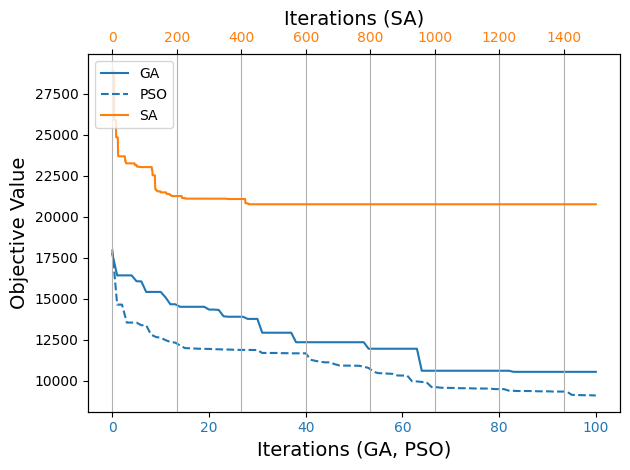

In [ ]:
import matplotlib.pyplot as plt

ga_fitness = [finess[0] for finess in ga_baseline_result["fitness_history"]]
pso_fitness = [finess[0] for finess in pso_baseline_result["fitness_history"]]
sa_fitness = [finess[0] for finess in sa_baseline_result["fitness_history"]]

fig, ax1 = plt.subplots()

# Plot for Method 1 (bottom x-axis)
color = 'tab:blue'
ax1.plot(range(len(ga_fitness)), ga_fitness, color=color, label='GA')
ax1.set_xlabel('Iterations (GA)')
ax1.set_ylabel('Objective Value', fontsize = 14)
ax1.tick_params(axis='x', labelcolor=color)

# Plot for Method 2 (bottom x-axis)
color = 'tab:blue'
ax1.plot(range(len(pso_fitness)), pso_fitness, linestyle='--', color=color, label='PSO')
ax1.set_xlabel('Iterations (GA, PSO)', fontsize = 14)
ax1.set_ylabel('Objective Value', fontsize = 14)
ax1.tick_params(axis='x', labelcolor=color)

# Create second x-axis (top) for Method 3
ax2 = ax1.twiny()
color = 'tab:orange'
ax2.plot(range(len(sa_fitness)), sa_fitness, color=color, label='SA')
ax2.set_xlabel('Iterations (SA)', fontsize = 14)
ax2.tick_params(axis='x', labelcolor=color)

# Optional: add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()

## Fitness scores

In [130]:
base_config_file = "configs/params.yaml" 
ga_exp_file0 = "exp_ga_0.pkl"
ga_exp_file1 = "exp_ga_1.pkl"
ga_exp_file2 = "exp_ga_2.pkl"
ga_exp_file3 = "exp_ga_3.pkl"
ga_exp_file4 = "exp_ga_4.pkl"
ga_exp_file5 = "exp_ga_5.pkl"
ga_exp_file6 = "exp_ga_6.pkl"
ga_exp_file7 = "exp_ga_7.pkl"
ga_exp_file8 = "exp_ga_8.pkl"
ga_exp_file9 = "exp_ga_9.pkl"


with open(ga_exp_file0, "rb") as f:
    ga_exp_result0 = pickle.load(f)
    print("Fitness score for GA_0:", int(ga_exp_result0["fitness_history"][-1][0]))

with open(ga_exp_file1, "rb") as f:
    ga_exp_result1 = pickle.load(f)
    print("Fitness score for GA_1:", int(ga_exp_result1["fitness_history"][-1][0]))

with open(ga_exp_file2, "rb") as f:
    ga_exp_result2 = pickle.load(f)
    print("Fitness score for GA_2:", int(ga_exp_result2["fitness_history"][-1][0]))

with open(ga_exp_file3, "rb") as f:
    ga_exp_result3 = pickle.load(f)
    print("Fitness score for GA_3:", int(ga_exp_result3["fitness_history"][-1][0]))

with open(ga_exp_file4, "rb") as f:
    ga_exp_result4 = pickle.load(f)
    print("Fitness score for GA_4:", int(ga_exp_result4["fitness_history"][-1][0]))

with open(ga_exp_file5, "rb") as f:
    ga_exp_result5 = pickle.load(f)
    print("Fitness score for GA_5:", int(ga_exp_result5["fitness_history"][-1][0]))

with open(ga_exp_file6, "rb") as f:
    ga_exp_result6 = pickle.load(f)
    print("Fitness score for GA_6:", int(ga_exp_result6["fitness_history"][-1][0]))

with open(ga_exp_file7, "rb") as f:
    ga_exp_result7 = pickle.load(f)
    print("Fitness score for GA_7:", int(ga_exp_result7["fitness_history"][-1][0]))

with open(ga_exp_file8, "rb") as f:
    ga_exp_result8 = pickle.load(f)
    print("Fitness score for GA_8:", int(ga_exp_result8["fitness_history"][-1][0]))

with open(ga_exp_file9, "rb") as f:
    ga_exp_result9 = pickle.load(f)
    print("Fitness score for GA_9:", int(ga_exp_result9["fitness_history"][-1][0]))



Fitness score for GA_0: 10545
Fitness score for GA_1: 9689
Fitness score for GA_2: 9764
Fitness score for GA_3: 10211
Fitness score for GA_4: 9854
Fitness score for GA_5: 10114
Fitness score for GA_6: 9406
Fitness score for GA_7: 9150
Fitness score for GA_8: 23438
Fitness score for GA_9: 14212


In [132]:
base_config_file = "configs/params.yaml" 
pso_exp_file0 = "exp_pso_0.pkl"
pso_exp_file1 = "exp_pso_1.pkl"
pso_exp_file2 = "exp_pso_2.pkl"
pso_exp_file3 = "exp_pso_3.pkl"
pso_exp_file4 = "exp_pso_4.pkl"
pso_exp_file5 = "exp_pso_5.pkl"
pso_exp_file6 = "exp_pso_6.pkl"
pso_exp_file7 = "exp_pso_7.pkl"
pso_exp_file8 = "exp_pso_8.pkl"
pso_exp_file9 = "exp_pso_9.pkl"
pso_exp_file10 = "exp_pso_10.pkl"


with open(pso_exp_file0, "rb") as f:
    pso_exp_result0 = pickle.load(f)
    print("Fitness score for PSO_0:", int(pso_exp_result0["fitness_history"][-1][0]))

with open(pso_exp_file1, "rb") as f:
    pso_exp_result1 = pickle.load(f)
    print("Fitness score for PSO_1:", int(pso_exp_result1["fitness_history"][-1][0]))

with open(pso_exp_file2, "rb") as f:
    pso_exp_result2 = pickle.load(f)
    print("Fitness score for PSO_2:", int(pso_exp_result2["fitness_history"][-1][0]))

with open(pso_exp_file3, "rb") as f:
    pso_exp_result3 = pickle.load(f)
    print("Fitness score for PSO_3:", int(pso_exp_result3["fitness_history"][-1][0]))

with open(pso_exp_file4, "rb") as f:
    pso_exp_result4 = pickle.load(f)
    print("Fitness score for PSO_4:", int(pso_exp_result4["fitness_history"][-1][0]))

with open(pso_exp_file5, "rb") as f:
    pso_exp_result5 = pickle.load(f)
    print("Fitness score for PSO_5:", int(pso_exp_result5["fitness_history"][-1][0]))

with open(pso_exp_file6, "rb") as f:
    pso_exp_result6 = pickle.load(f)
    print("Fitness score for PSO_6:", int(pso_exp_result6["fitness_history"][-1][0]))

with open(pso_exp_file7, "rb") as f:
    pso_exp_result7 = pickle.load(f)
    print("Fitness score for PSO_7:", int(pso_exp_result7["fitness_history"][-1][0]))

with open(pso_exp_file8, "rb") as f:
    pso_exp_result8 = pickle.load(f)
    print("Fitness score for PSO_8:", int(pso_exp_result8["fitness_history"][-1][0]))

with open(pso_exp_file9, "rb") as f:
    pso_exp_result9 = pickle.load(f)
    print("Fitness score for PSO_9:", int(pso_exp_result9["fitness_history"][-1][0]))
    
with open(pso_exp_file10, "rb") as f:
    pso_exp_result10 = pickle.load(f)
    print("Fitness score for PSO_10:", int(pso_exp_result10["fitness_history"][-1][0]))



Fitness score for PSO_0: 12207
Fitness score for PSO_1: 9105
Fitness score for PSO_2: 8572
Fitness score for PSO_3: 8380
Fitness score for PSO_4: 7269
Fitness score for PSO_5: 8656
Fitness score for PSO_6: 9516
Fitness score for PSO_7: 8313
Fitness score for PSO_8: 8732
Fitness score for PSO_9: 19067
Fitness score for PSO_10: 11567


In [169]:
sa_exp_file0 = "exp_sa_0.pkl"
sa_exp_file1 = "exp_sa_1.pkl"
sa_exp_file2 = "exp_sa_2.pkl"
sa_exp_file3 = "exp_sa_3.pkl"
sa_exp_file4 = "exp_sa_4.pkl"
sa_exp_file5 = "exp_sa_5.pkl"
sa_exp_file6 = "exp_sa_6.pkl"
sa_exp_file7 = "exp_sa_7.pkl"
sa_exp_file8 = "exp_sa_8.pkl"
sa_exp_file9 = "exp_sa_9.pkl"
sa_exp_file10 = "exp_sa_10.pkl"


with open(sa_exp_file0, "rb") as f:
    sa_exp_result0 = pickle.load(f)
    f1 = sa_exp_result0["fitness_history"][0][0]
    f2 = sa_exp_result0["fitness_history"][-1][0]
    print("Fitness score for SA_0:", int(f2))

with open(sa_exp_file1, "rb") as f:
    sa_exp_result1 = pickle.load(f)
    f1 = sa_exp_result1["fitness_history"][0][0]
    f2 = sa_exp_result1["fitness_history"][-1][0]
    print("Fitness score for SA_1:", int(f2))

with open(sa_exp_file2, "rb") as f:
    sa_exp_result2 = pickle.load(f)
    f1 = sa_exp_result2["fitness_history"][0][0]
    f2 = sa_exp_result2["fitness_history"][-1][0]
    print("Fitness score for SA_2:", int(f2))

with open(sa_exp_file3, "rb") as f:
    sa_exp_result3 = pickle.load(f)
    f1 = sa_exp_result3["fitness_history"][0][0]
    f2 = sa_exp_result3["fitness_history"][-1][0]
    print("Fitness score for SA_3:", int(f2))

with open(sa_exp_file4, "rb") as f:
    sa_exp_result4 = pickle.load(f)
    f1 = sa_exp_result4["fitness_history"][0][0]
    f2 = sa_exp_result4["fitness_history"][-1][0]
    print("Fitness score for SA_4:", int(f2))

with open(sa_exp_file5, "rb") as f:
    sa_exp_result5 = pickle.load(f)
    f1 = sa_exp_result5["fitness_history"][0][0]
    f2 = sa_exp_result5["fitness_history"][-1][0]
    print("Fitness score for SA_5:", int(f2))

with open(sa_exp_file6, "rb") as f:
    sa_exp_result6 = pickle.load(f)
    f1 = sa_exp_result6["fitness_history"][0][0]
    f2 = sa_exp_result6["fitness_history"][-1][0]
    print("Fitness score for SA_6:", int(f2))

with open(sa_exp_file7, "rb") as f:
    sa_exp_result7 = pickle.load(f)
    f1 = sa_exp_result7["fitness_history"][0][0]
    f2 = sa_exp_result7["fitness_history"][-1][0]
    print("Fitness score for SA_7:", int(f2))

with open(sa_exp_file8, "rb") as f:
    sa_exp_result8 = pickle.load(f)
    print("Fitness score for SA_8:", int(sa_exp_result8["fitness_history"][-1][0]))

with open(sa_exp_file9, "rb") as f:
    sa_exp_result9 = pickle.load(f)
    print("Fitness score for SA_9:", int(sa_exp_result9["fitness_history"][-1][0]))
    
with open(sa_exp_file10, "rb") as f:
    sa_exp_result10 = pickle.load(f)
    print("Fitness score for SA_10:", int(sa_exp_result10["fitness_history"][-1][0]))



Fitness score for SA_0: 20759
Fitness score for SA_1: 17996
Fitness score for SA_2: 16768
Fitness score for SA_3: 17885
Fitness score for SA_4: 21661
Fitness score for SA_5: 34313
Fitness score for SA_6: 18965
Fitness score for SA_7: 10359
Fitness score for SA_8: 5729
Fitness score for SA_9: 5658
Fitness score for SA_10: 8663


## Comparison of best experiments

In [182]:
ga_best_solution = ga_exp_result6["solution"]
ga_best_evaluation = evaluate_solution(ga_best_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)

print("Evaluation of GA with baseline parameters:")
print("-----------------------------------------")
print("fitness: ", ga_best_evaluation["fitness"], "\ncs_cost: ", ga_best_evaluation["cs_cost"], "\navg_charging_time_kWh: ", ga_best_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", ga_best_evaluation["avg_distance"], "\ngrid_loss: ", ga_best_evaluation["grid_loss"], "\navg_utilization_rate: ", ga_best_evaluation["avg_utilization_rate"])
print()

pso_best_solution = pso_exp_result4["solution"]
pso_best_evaluation = evaluate_solution(pso_best_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)
print("Evaluation of PSO with baseline parameters:")
print("-----------------------------------------")
print("fitness: ", pso_best_evaluation["fitness"], "\ncs_cost: ", pso_best_evaluation["cs_cost"], "\navg_charging_time_kWh: ", pso_best_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", pso_best_evaluation["avg_distance"], "\ngrid_loss: ", pso_best_evaluation["grid_loss"], "\navg_utilization_rate: ", pso_best_evaluation["avg_utilization_rate"])
print()

sa_best_solution = sa_exp_result2["solution"]
sa_best_evaluation = evaluate_solution(sa_best_solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)
print("Evaluation of SA with baseline parameters:")
print("-----------------------------------------")
print("fitness: ", sa_best_evaluation["fitness"], "\ncs_cost: ", sa_best_evaluation["cs_cost"], "\navg_charging_time_kWh: ", sa_best_evaluation["avg_charging_time_kWh"], 
      "\navg_distance: ", sa_best_evaluation["avg_distance"], "\ngrid_loss: ", sa_best_evaluation["grid_loss"], "\navg_utilization_rate: ", sa_best_evaluation["avg_utilization_rate"])
print()

Evaluation of GA with baseline parameters:
-----------------------------------------
fitness:  9406.546156832512 
cs_cost:  1352000.0 
avg_charging_time_kWh:  0.6758523010997237 
avg_distance:  441.8686470588235 
grid_loss:  25659.818074565872 
avg_utilization_rate:  0.006235882455656937

Evaluation of PSO with baseline parameters:
-----------------------------------------
fitness:  7269.235342574772 
cs_cost:  830500.0 
avg_charging_time_kWh:  0.5522439206500053 
avg_distance:  342.8455882352941 
grid_loss:  24905.98569718046 
avg_utilization_rate:  0.006543548000391407

Evaluation of SA with baseline parameters:
-----------------------------------------
fitness:  16768.856980098168 
cs_cost:  1157500.0 
avg_charging_time_kWh:  0.6357983075321699 
avg_distance:  1219.8920588235294 
grid_loss:  23344.48542020204 
avg_utilization_rate:  0.006447663189566774



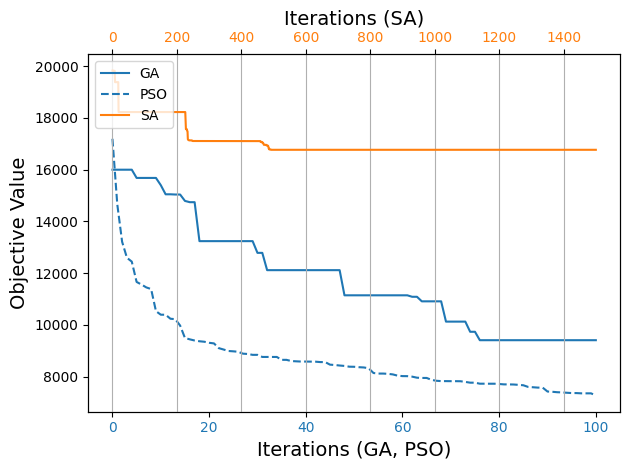

In [183]:
ga_fitness = [finess[0] for finess in ga_exp_result6["fitness_history"]]
pso_fitness = [finess[0] for finess in pso_exp_result4["fitness_history"]]
sa_fitness = [finess[0] for finess in sa_exp_result2["fitness_history"]]

fig, ax1 = plt.subplots()

# Plot for GA
color = 'tab:blue'
ax1.plot(range(len(ga_fitness)), ga_fitness, color=color, label='GA')
ax1.set_xlabel('Iterations (GA)')
ax1.set_ylabel('Objective Value', fontsize = 14)
ax1.tick_params(axis='x', labelcolor=color)

# Plot for PSO
color = 'tab:blue'
ax1.plot(range(len(pso_fitness)), pso_fitness, linestyle='--', color=color, label='PSO')
ax1.set_xlabel('Iterations (GA, PSO)', fontsize = 14)
ax1.set_ylabel('Objective Value', fontsize = 14)
ax1.tick_params(axis='x', labelcolor=color)

# Plot for SA
ax2 = ax1.twiny()
color = 'tab:orange'
ax2.plot(range(len(sa_fitness)), sa_fitness, color=color, label='SA')
ax2.set_xlabel('Iterations (SA)', fontsize = 14)
ax2.tick_params(axis='x', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.grid()
plt.show()